In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
import seaborn as sns

In [2]:
plt.style.use("default")
sns.set_theme(
    context="paper",
    style="white",
    palette="tab10",
    font="serif",
    font_scale=1.5,
    color_codes=True,
    rc={"text.usetex": True},
)
os.makedirs("../figures/SCALING/", exist_ok=True)
fig_dir = "../figures/SCALING/"

In [3]:
def load_experiment_data(root_dir: str, lr: float = 0.001) -> pd.DataFrame:
    """Load experiment data from complex directory structure"""
    records = []
    root_path = Path(root_dir)

    # Find all terminal seed directories containing results
    for seed_dir in root_path.glob("**/seed=*/"):
        # Extract parameters from path components
        params = {
            "hidden_size": None,
            "dataset_size": None,
            "lr": None,
            "seed": int(seed_dir.name.split("=")[1]),
        }

        # Parse parameters from parent directories
        for parent in seed_dir.parents:
            if parent.name.startswith("hidden_size="):
                params["hidden_size"] = int(parent.name.split("=")[1])
            elif parent.name.startswith("dataset_size="):
                params["dataset_size"] = int(parent.name.split("=")[1])
            elif parent.name.startswith("lr="):
                params["lr"] = float(parent.name.split("=")[1])

        # Validate all parameters found
        if None in params.values():
            missing = [k for k, v in params.items() if v is None]
            print(f"Skipping {seed_dir} - missing: {missing}")
            continue

        try:
            # Load metrics files
            test_losses = np.loadtxt(seed_dir / "test_losses.txt")
            train_losses = np.loadtxt(seed_dir / "train_losses.txt")
            control = np.loadtxt(seed_dir / "controls.txt")
            epochs = np.loadtxt(seed_dir / "epochs.txt")

            records.append(
                {
                    **params,
                    "test_loss": test_losses,
                    "train_loss": train_losses,
                    "epoch": epochs,
                    "control": control,
                }
            )
        except Exception as e:
            print(f"Error loading {seed_dir}: {str(e)}")
            continue

    return pd.DataFrame(records)

In [4]:
growing_df = load_experiment_data("../output/bessel_regression/task=regression/")
baseline_df = load_experiment_data(
    "../output/bessel_regression_baseline/task=regression/"
)

# growing_df = load_experiment_data("../output_old/bessel_regression/")
# baseline_df = load_experiment_data("../output_old/bessel_regression_baseline/")

In [5]:
def calculate_mean_std_across_runs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the mean and standard deviation of array-valued columns
    across different runs, grouping by all *scalar* columns *except* the 'seed' column.
    """

    if "seed" not in df.columns:
        raise ValueError("DataFrame must contain a 'seed' column.")

    array_cols = [col for col in df.columns if isinstance(df[col].iloc[0], np.ndarray)]

    if not array_cols:
        raise ValueError("No array-valued columns found.")

    scalar_cols = [col for col in df.columns if col != "seed" and col not in array_cols]

    def mean(x: pd.Series) -> np.ndarray:
        """Calculates the mean array across runs."""
        return np.mean(np.stack(x.values), axis=0)

    def std(x: pd.Series) -> np.ndarray:
        """Calculates the standard deviation array across runs."""
        return np.std(np.stack(x.values), axis=0)

    grouped = df.groupby(scalar_cols)

    # Calculate the mean and std for each array-valued column
    agg_dict = {col: [mean, std] for col in array_cols}
    result = grouped.agg(agg_dict)

    # Flatten the multi-level column index
    result.columns = [
        "_".join(col).strip() for col in result.columns.values
    ]  # More robust flattening

    return result

In [6]:
processed_growing = calculate_mean_std_across_runs(growing_df)
processed_baseline = calculate_mean_std_across_runs(baseline_df)

In [7]:
lr = 3e-4
dataset_size = 2**15
# dataset_size = 100000

In [8]:
processed_growing

test_loss_mean  \
hidden_size dataset_size lr                                                          
4           32768        0.0001  [0.8405512869358063, 0.8276322662830353, 0.815...   
                         0.0003  [0.8402894914150238, 0.8024699985980988, 0.766...   
                         0.0010  [0.8393740892410279, 0.7209465563297272, 0.614...   
8           32768        0.0001  [0.777827799320221, 0.7666619956493378, 0.7558...   
                         0.0003  [0.7776007294654846, 0.7449402868747711, 0.714...   
                         0.0010  [0.7768068373203277, 0.6741332590579987, 0.583...   
16          32768        0.0001  [0.745338249206543, 0.7352043390274048, 0.7253...   
                         0.0003  [0.7451322615146637, 0.7155340909957886, 0.687...   
                         0.0010  [0.7444122850894928, 0.650523579120636, 0.5752...   
32          32768        0.0001  [0.7282958567142487, 0.7188062548637391, 0.709...   
                         0.0003  [0.7281029105186463, 0.7003339529037476, 0.673...   
                         0.0010  [0.727428388595581, 0.6382788717746735, 0.5700...   
64          32768        0.0001  [0.7192098319530487, 0.7100364327430725, 0.701...   
                         0.0003  [0.7190233767032623, 0.6920157432556152, 0.665...   
                         0.0010  [0.7183716297149658, 0.631632137298584, 0.5623...   
128         32768        0.0001  [0.7142668128013611, 0.7051805019378662, 0.696...   
                         0.0003  [0.7140824258327484, 0.6870516300201416, 0.659...   
                         0.0010  [0.7134379088878632, 0.6307455718517303, 0.551...   
256         32768        0.0001  [0.7115130841732025, 0.7024650037288666, 0.693...   
                         0.0003  [0.7113301753997803, 0.683817321062088, 0.6556...   
                         0.0010  [0.7106907606124878, 0.630586463212967, 0.5297...   
512         32768        0.0001  [0.7099366962909699, 0.7008820950984955, 0.691...   
                         0.0003  [0.7097548067569732, 0.6811829149723053, 0.655...   
                         0.0010  [0.7091190338134765, 0.6287658929824829, 0.478...   
1024        32768        0.0001  [0.7090073764324188, 0.6998644292354583, 0.689...   
                         0.0003  [0.7088262379169464, 0.6781913042068481, 0.654...   
                         0.0010  [0.7081930756568908, 0.6257721424102783, 0.409...   

                                                                     test_loss_std  \
hidden_size dataset_size lr                                                          
4           32768        0.0001  [0.13468639638912963, 0.13094216475127943, 0.1...   
                         0.0003  [0.13461113760376217, 0.12345079631144856, 0.1...   
                         0.0010  [0.13434798189349229, 0.09716628301978623, 0.0...   
8           32768        0.0001  [0.08174742360172776, 0.078645624413805, 0.075...   
                         0.0003  [0.0816855517328943, 0.07248316663807408, 0.06...   
                         0.0010  [0.08146908695051137, 0.050745968423838966, 0....   
16          32768        0.0001  [0.0519659050446166, 0.0494557401791537, 0.046...   
                         0.0003  [0.05191577784919188, 0.04431587821447065, 0.0...   
                         0.0010  [0.05174039187621842, 0.024882427154760682, 0....   
32          32768        0.0001  [0.03436982056552644, 0.03233406243514023, 0.0...   
                         0.0003  [0.034329044868166333, 0.02817172993124413, 0....   
                         0.0010  [0.03418641893471201, 0.011924105735871568, 0....   
64          32768        0.0001  [0.0234909448988318, 0.021909261188081855, 0.0...   
                         0.0003  [0.023459304545220213, 0.018582259088522162, 0...   
                         0.0010  [0.023348633190935372, 0.006594618716926452, 0...   
128         32768        0.0001  [0.01654275714741745, 0.015423195077665831, 0....   
                         

In [9]:
single_param_growing = processed_growing[
    processed_growing.index.get_level_values("lr") == lr
]
single_param_growing = single_param_growing[
    single_param_growing.index.get_level_values("dataset_size") == dataset_size
]

In [10]:
single_param_growing.head()

,,,test_loss_mean,test_loss_std,train_loss_mean,train_loss_std,epoch_mean,epoch_std,control_mean,control_std
hidden_size,dataset_size,lr,,,,,,,,
4,32768,0.0003,"[0.8402894914150238, 0.8024699985980988, 0.766...","[0.13461113760376217, 0.12345079631144856, 0.1...","[0.8409977555274963, 0.8031698822975158, 0.767...","[0.13695546193028985, 0.12579496222647102, 0.1...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00029648735362570734, 0.030139082111418247,...","[8.068000935493712e-06, 8.067045877875149e-06,..."
8,32768,0.0003,"[0.7776007294654846, 0.7449402868747711, 0.714...","[0.0816855517328943, 0.07248316663807408, 0.06...","[0.7783652067184448, 0.7457736551761627, 0.715...","[0.08334708920264547, 0.07405687143102746, 0.0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00029648735362570734, 0.030139082111418247,...","[8.068000935493712e-06, 8.067045877875149e-06,..."
16,32768,0.0003,"[0.7451322615146637, 0.7155340909957886, 0.687...","[0.05191577784919188, 0.04431587821447065, 0.0...","[0.7459416866302491, 0.7164236009120941, 0.688...","[0.052972598359029024, 0.04525785015012286, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00029648735362570734, 0.030139082111418247,...","[8.068000935493712e-06, 8.067045877875149e-06,..."
32,32768,0.0003,"[0.7281029105186463, 0.7003339529037476, 0.673...","[0.034329044868166333, 0.02817172993124413, 0....","[0.7289469718933106, 0.7012029945850372, 0.674...","[0.03485817112414404, 0.02857282426806499, 0.0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00029648735362570734, 0.030139082111418247,...","[8.068000935493712e-06, 8.067045877875149e-06,..."
64,32768,0.0003,"[0.7190233767032623, 0.6920157432556152, 0.665...","[0.023459304545220213, 0.018582259088522162, 0...","[0.7198959589004517, 0.6928436577320098, 0.665...","[0.023517657481959407, 0.01850419828250765, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00029648735362570734, 0.030139082111418247,...","[8.068000935493712e-06, 8.067045877875149e-06,..."


In [11]:
single_param_baseline = processed_baseline[
    processed_baseline.index.get_level_values("lr") == lr
]
single_param_baseline = single_param_baseline[
    single_param_baseline.index.get_level_values("dataset_size") == dataset_size
]

In [12]:
single_param_baseline.head()

,,,test_loss_mean,test_loss_std,train_loss_mean,train_loss_std,epoch_mean,epoch_std,control_mean,control_std
hidden_size,dataset_size,lr,,,,,,,,
4,32768,0.0003,"[0.5912183284759521, 0.5198270887136459, 0.473...","[0.39193362899688927, 0.3063870545588023, 0.23...","[0.5953381538391114, 0.5232863813638687, 0.476...","[0.4005029419677487, 0.3140670215991978, 0.242...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,32768,0.0003,"[0.650734281539917, 0.5030006259679795, 0.4306...","[0.22474908921030437, 0.13492129583808973, 0.0...","[0.6517411470413208, 0.5037733018398285, 0.431...","[0.2296129063511392, 0.1385043667878192, 0.074...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,32768,0.0003,"[0.46514755189418794, 0.38365418910980226, 0.3...","[0.07357452975388701, 0.016836473171015397, 0....","[0.46947125196456907, 0.3849018394947052, 0.36...","[0.07340239138566171, 0.015766336576432383, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
32,32768,0.0003,"[0.51282539665699, 0.3817644029855728, 0.36393...","[0.1667811434041133, 0.02272623023738483, 0.01...","[0.5164211601018905, 0.38219931423664094, 0.36...","[0.1699299316718771, 0.025617870868513703, 0.0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
64,32768,0.0003,"[0.4852122366428375, 0.36554857194423673, 0.35...","[0.10689299290792523, 0.006452629920365842, 0....","[0.4899662613868713, 0.366076797246933, 0.3552...","[0.1121887768595432, 0.00581060527354782, 0.00...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
epochs = single_param_baseline["epoch_mean"].values[0]

In [14]:
single_param_baseline["test_loss_mean"].values

array([array([0.59121833, 0.51982709, 0.47369845, 0.44259507, 0.42093345,
              0.40531508, 0.39366182, 0.38472839, 0.37768427, 0.37186248,
              0.36676531, 0.3620649 , 0.35751003, 0.35285035, 0.34781829,
              0.34224561, 0.33619506, 0.32981166, 0.32318833, 0.31636537,
              0.30934718, 0.30212138, 0.29469516, 0.28709374, 0.27932373,
              0.27140266, 0.26339943, 0.25539976, 0.24746158, 0.23960748,
              0.23183549, 0.2241214 , 0.21641273, 0.20865634, 0.20088804,
              0.19325039, 0.1858992 , 0.17893702, 0.17240549, 0.16630442,
              0.16061193, 0.15529668, 0.15032314, 0.14565316, 0.14124616,
              0.13706026, 0.13305518, 0.12919473, 0.12544349, 0.12175602]),
       array([0.65073428, 0.50300063, 0.43068292, 0.39528105, 0.3780708 ,
              0.36988167, 0.36575181, 0.36311693, 0.36081872, 0.35838726,
              0.35561766, 0.35238131, 0.34855332, 0.34397656, 0.33850056,
              0.33211006, 0.32491758

In [15]:
hidden_sizes = single_param_baseline.index.get_level_values("hidden_size").unique()[:]

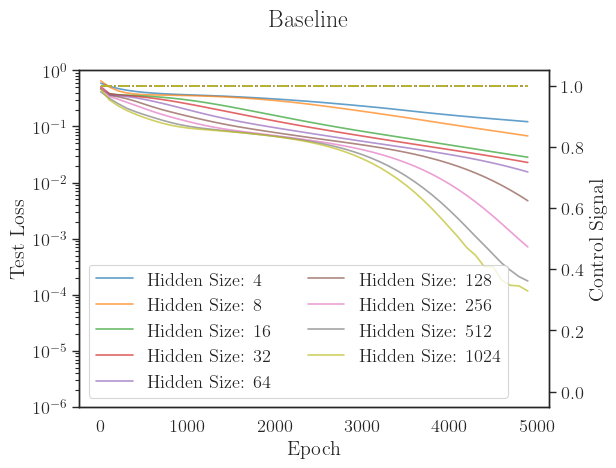

In [16]:
fig, ax1 = plt.subplots()

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_baseline["test_loss_mean"].values[i],
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_baseline["test_loss_mean"].values[i]
    #     - single_param_baseline["test_loss_std"].values[i],
    #     single_param_baseline["test_loss_mean"].values[i]
    #     + single_param_baseline["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
ax1.legend(loc="best", ncol=2)
ax1.set_ylim(1e-6, 1)

# Create a second y-axis for the control signal
ax2 = ax1.twinx()
for i in range(len(hidden_sizes)):
    ax2.plot(
        epochs,
        single_param_baseline["control_mean"].values[i],
        "-.",
        label=f"Hidden Size: {hidden_sizes[i]}",
    )

ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel("Control Signal")
# ax2.legend(loc="upper right")
plt.suptitle("Baseline")
plt.tight_layout()

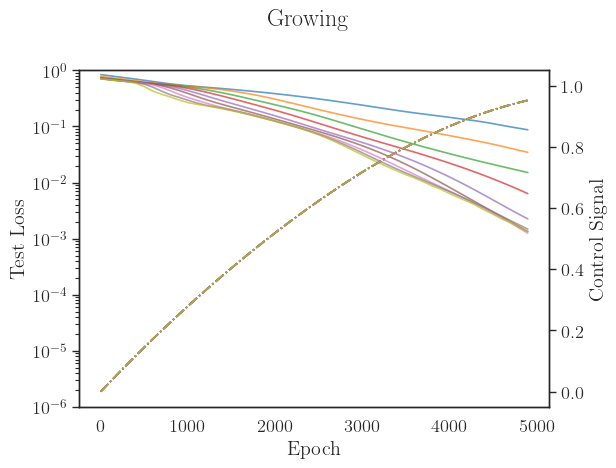

In [17]:
fig, ax1 = plt.subplots()

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_growing["test_loss_mean"].values[i],
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_growing["test_loss_mean"].values[i]
    #     - single_param_growing["test_loss_std"].values[i],
    #     single_param_growing["test_loss_mean"].values[i]
    #     + single_param_growing["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
# ax1.legend(loc="best")
ax1.set_ylim(1e-6, 1)

# Create a second y-axis for the control signal
ax2 = ax1.twinx()
for i in range(len(hidden_sizes)):
    ax2.plot(
        epochs,
        single_param_growing["control_mean"].values[i],
        "-.",
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )

ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel("Control Signal")
# ax2.legend(loc="upper right")
plt.suptitle("Growing")
plt.tight_layout()

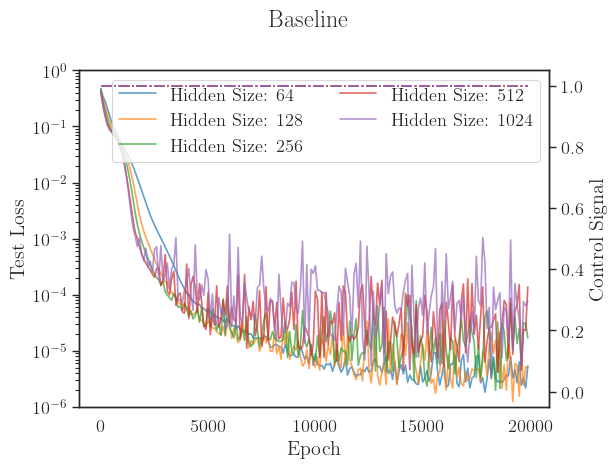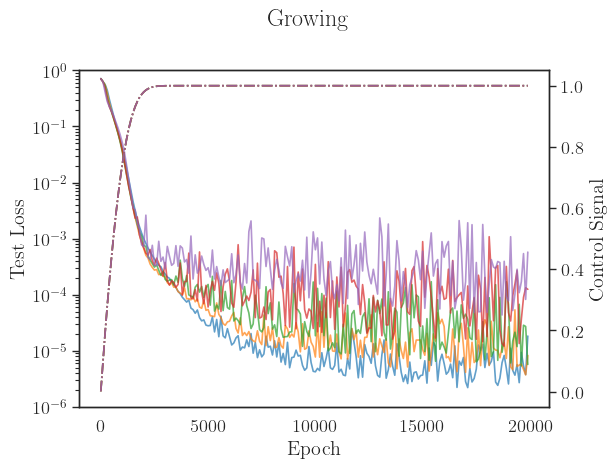

/tmp/ipykernel_645552/1211567928.py:72: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


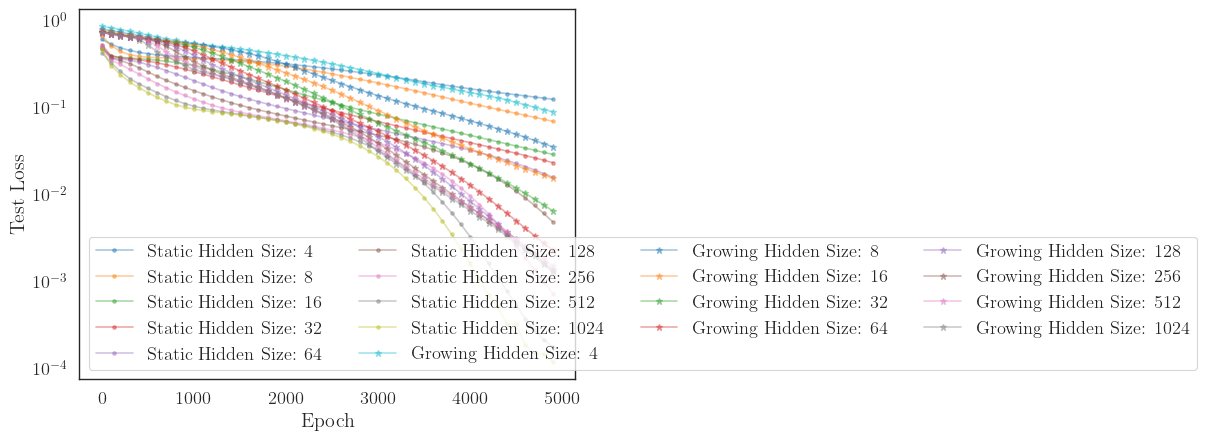

In [18]:
fig, ax1 = plt.subplots()
for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_baseline["test_loss_mean"].values[i],
        ".-",
        label=f"Static Hidden Size: {hidden_sizes[i]}",
        alpha=0.4,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_baseline["test_loss_mean"].values[i]
    #     - single_param_baseline["test_loss_std"].values[i],
    #     single_param_baseline["test_loss_mean"].values[i]
    #     + single_param_baseline["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
# ax1.legend(loc="best")
# ax1.set_ylim(1e-5, 1)

# # Create a second y-axis for the control signal
# ax2 = ax1.twinx()
# for i in range(len(hidden_sizes)):
#     ax2.plot(
#         epochs,
#         single_param_baseline["control_mean"].values[i],
#         "-.",
#         label=f"Hidden Size: {hidden_sizes[i]}",
#     )

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_growing["test_loss_mean"].values[i],
        "*-",
        label=f"Growing Hidden Size: {hidden_sizes[i]}",
        alpha=0.4,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_growing["test_loss_mean"].values[i]
    #     - single_param_growing["test_loss_std"].values[i],
    #     single_param_growing["test_loss_mean"].values[i]
    #     + single_param_growing["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
ax1.legend(loc="best", ncol=4)
# ax1.set_ylim(1e-5, 1)

# # Create a second y-axis for the control signal
# ax2 = ax1.twinx()
# for i in range(len(hidden_sizes)):
#     ax2.plot(
#         epochs,
#         single_param_growing["control_mean"].values[i],
#         "-.",
#         label=f"Hidden Size: {hidden_sizes[i]}",
#         alpha=0.7,
#     )

ax2.set_ylim(-0.05, 1.05)
plt.tight_layout()

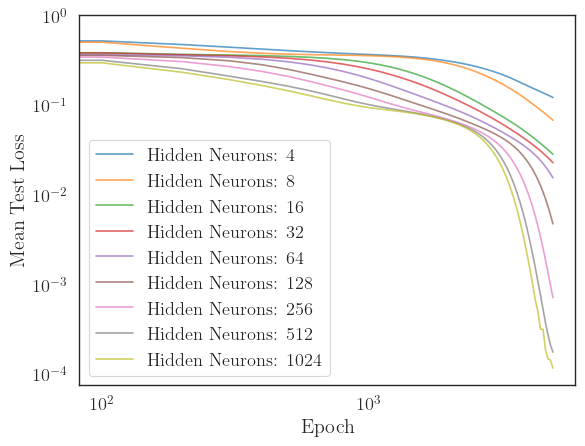

In [19]:
for i, loss in enumerate(single_param_baseline["test_loss_mean"].values):
    plt.plot(epochs, loss, label=f"Hidden Neurons: {hidden_sizes[i]}", alpha=0.7)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean Test Loss")
plt.xscale("log")
plt.yscale("log")

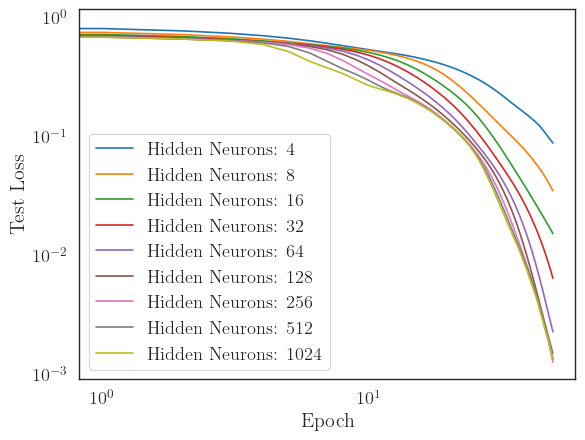

In [20]:
for i, loss in enumerate(single_param_growing["test_loss_mean"].values):
    plt.plot(loss, label=f"Hidden Neurons: {hidden_sizes[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.xscale("log")
plt.yscale("log")

In [21]:
epochs[-1]

np.float64(4900.0)

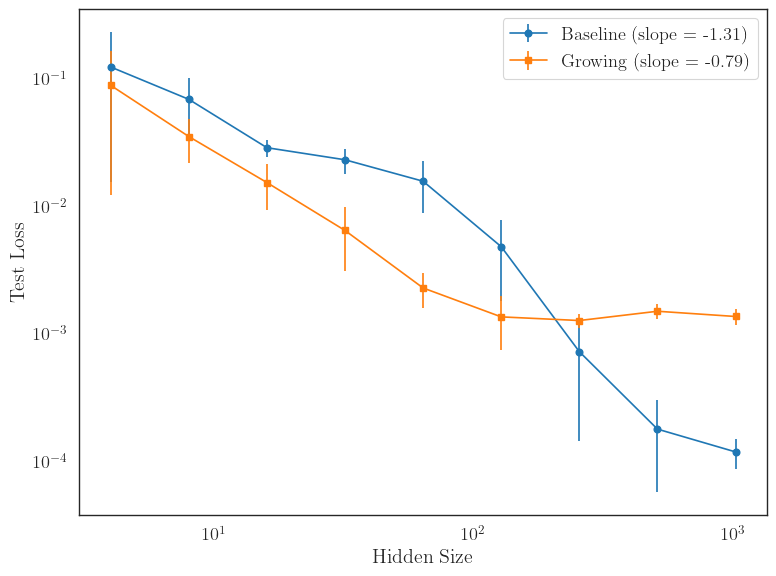

In [22]:
def extract_epoch_test_loss(df):
    return df["test_loss_mean"].apply(lambda x: x[-1]), df["test_loss_std"].apply(
        lambda x: x[-1]
    )


final_loss_baseline, final_loss_baseline_std = extract_epoch_test_loss(
    single_param_baseline
)
final_loss_growing, final_loss_growing_std = extract_epoch_test_loss(
    single_param_growing
)

# Get the hidden sizes associated with each run (they are the first level of the index)
hs_baseline = final_loss_baseline.index.get_level_values("hidden_size").astype(float)
hs_growing = final_loss_growing.index.get_level_values("hidden_size").astype(float)

# Fit a power law (linear fit in log–log coordinates) for each experiment
log_hs_baseline = np.log(hs_baseline)
log_loss_baseline = np.log(final_loss_baseline)
slope_baseline, intercept_baseline = np.polyfit(log_hs_baseline, log_loss_baseline, 1)

log_hs_growing = np.log(hs_growing)
log_loss_growing = np.log(final_loss_growing)
slope_growing, intercept_growing = np.polyfit(log_hs_growing, log_loss_growing, 1)

# Plot the scaling laws with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(
    hs_baseline,
    final_loss_baseline,
    yerr=final_loss_baseline_std,
    fmt="o-",
    label=f"Baseline (slope = {slope_baseline:.2f})",
)
plt.errorbar(
    hs_growing,
    final_loss_growing,
    yerr=final_loss_growing_std,
    fmt="s-",
    label=f"Growing (slope = {slope_growing:.2f})",
)
plt.xlabel("Hidden Size")
plt.ylabel("Test Loss")
# plt.ylim(1e-5, 1e-2)
plt.xscale("log")
plt.yscale("log")
# plt.title("Scaling Law: Test Loss vs Hidden Size")
plt.legend()
plt.tight_layout()
plt.savefig(
    fig_dir + f"regression_scaling_loss_hidden_{lr}_{dataset_size}_{epochs[-1]}.pdf"
)
plt.savefig(
    fig_dir + f"regression_scaling_loss_hidden_{lr}_{dataset_size}_{epochs[-1]}.svg"
)
plt.savefig(
    fig_dir + f"regression_scaling_loss_hidden_{lr}_{dataset_size}_{epochs[-1]}.png"
)